# Operator average

This notebook demonstrates how to compute the expectation value of an Hamiltonian operator and its derivative with respect to the Hamiltonian coefficients.

In [1]:
import numpy as np
import chemtensor
import matplotlib.pyplot as plt

### Construct Heisenberg XXZ Hamiltonian

In [2]:
# number of lattice sites
nsites = 8

# Hamiltonian parameters
J =  1
D =  1.3
h = -0.8

In [3]:
help(chemtensor.construct_heisenberg_xxz_1d_mpo)

Help on built-in function construct_heisenberg_xxz_1d_mpo in module chemtensor:

construct_heisenberg_xxz_1d_mpo(...)
    Construct an MPO representation of the XXZ Heisenberg Hamiltonian 'sum J (X X + Y Y + D Z Z) - h Z' on a one-dimensional lattice.
    Syntax: construct_heisenberg_xxz_1d_mpo(nsites: int, J: float, D: float, h: float)



In [4]:
hamiltonian = chemtensor.construct_heisenberg_xxz_1d_mpo(nsites, J, D, h)

In [5]:
# spin quantum numbers (times 2) at each site
hamiltonian.qsite

[1, -1]

In [6]:
# (0, 1, J/2, J*D, -h)
hamiltonian.coeffmap

array([0. , 1. , 0.5, 1.3, 0.8])

### Evaluate $\langle \chi | H | \psi \rangle$ and its derivatives with respect to Hamiltonian coefficients

In [7]:
# generate two random normalized MPS
psi = chemtensor.construct_random_mps("double", hamiltonian.nsites, hamiltonian.qsite, 2, rng_seed=42)
chi = chemtensor.construct_random_mps("double", hamiltonian.nsites, hamiltonian.qsite, 2, rng_seed=43)

In [8]:
psi.bond_dims

[1, 2, 4, 8, 10, 8, 4, 2, 1]

In [9]:
chi.bond_dims

[1, 2, 4, 8, 10, 8, 4, 2, 1]

In [10]:
# state is normalized
np.linalg.norm(psi.to_statevector())

0.9999999999999999

In [11]:
# compute <chi | H | psi> and its derivatives with respect to Hamiltonian coefficients
avr, grad = chemtensor.operator_average_coefficient_gradient(hamiltonian, psi, chi)
avr, grad

(array(0.47779349),
 array([ 0.        ,  3.34455446,  1.0562261 , -0.05601596,  0.02812649]))

In [12]:
# reference calculation
Dlist = np.linspace(0.7, 1.9, 9)
avr_list = []
for Di in Dlist:
    # modified Hamiltonian (D parameter varies)
    hamiltonian_mod = chemtensor.construct_heisenberg_xxz_1d_mpo(nsites, J, Di, h)
    avr_i, _ = chemtensor.operator_average_coefficient_gradient(hamiltonian_mod, psi, chi)
    avr_list.append(float(avr_i))

In this example, the linear extrapolation based on the gradient matches the evaluation with respect to the modified Hamiltonian exactly since it depends linearly on the parameters.

In [13]:
np.linalg.norm(avr_list - np.array([avr + grad[3]*(Di - D) for Di in Dlist]))

2.0014830212433605e-16

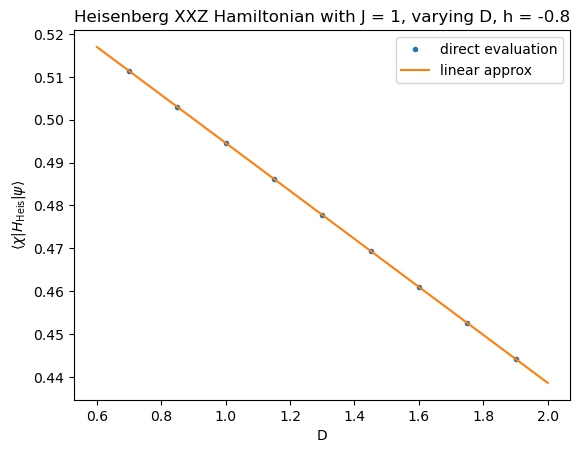

In [14]:
# visualize data
Dgrid = np.linspace(0.6, 2, 101)
avr_grad = [avr + grad[3]*(Dg - D) for Dg in Dgrid]
plt.plot(Dlist, avr_list, '.', label="direct evaluation")
plt.plot(Dgrid, avr_grad, label="linear approx")
plt.xlabel("D")
plt.ylabel(r"$\langle \chi | H_{\mathrm{Heis}} | \psi \rangle$")
plt.legend()
plt.title(f"Heisenberg XXZ Hamiltonian with J = {J}, varying D, h = {h}")
plt.show()

### Demonstration of Hellmann–Feynman theorem

Here we compute expectation values with respect to eigenstates of the modified Hamiltonian, instead of using fixed quantum states.

In [15]:
# run two-site DMRG; note: this is not the ground state quantum sector
phi, en_sweeps, entropy = chemtensor.dmrg(hamiltonian, qnum_sector=2)

In [16]:
avr_eig, grad_eig = chemtensor.operator_average_coefficient_gradient(hamiltonian, phi, phi)
avr_eig, grad_eig

(array(-2.45742935),
 array([  0.        , -17.20200544,  -4.0605414 ,  -0.94396819,
          1.        ]))

In [17]:
# difference should be numerically zero
avr_eig - en_sweeps[-1]

0.0

In [18]:
# compute expectation values with respect to eigenstate of Hamiltonian with modified D parameter
avr_eig_list = []
for Di in Dlist:
    # modified Hamiltonian (D parameter varies)
    hamiltonian_mod = chemtensor.construct_heisenberg_xxz_1d_mpo(nsites, J, Di, h)
    _, en_sweeps, _ = chemtensor.dmrg(hamiltonian_mod, qnum_sector=2)
    avr_eig_list.append(en_sweeps[-1])

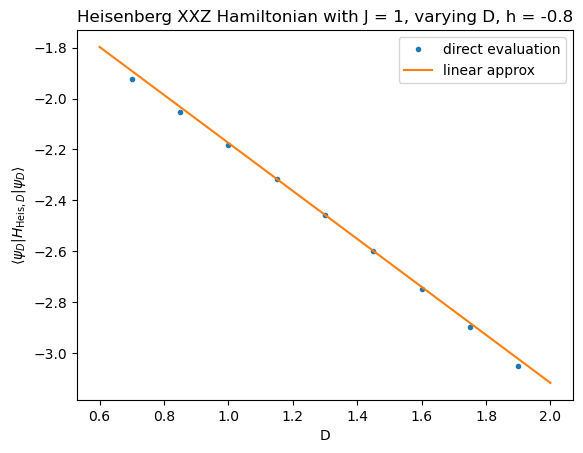

In [19]:
# visualize data
avr_eig_grad = [avr_eig + grad_eig[3]*(Dg - D) for Dg in Dgrid]
plt.plot(Dlist, avr_eig_list, '.', label="direct evaluation")
plt.plot(Dgrid, avr_eig_grad, label="linear approx")
plt.xlabel("D")
plt.ylabel(r"$\langle \psi_D | H_{\mathrm{Heis}, D} | \psi_D \rangle$")
plt.legend()
plt.title(f"Heisenberg XXZ Hamiltonian with J = {J}, varying D, h = {h}")
plt.show()

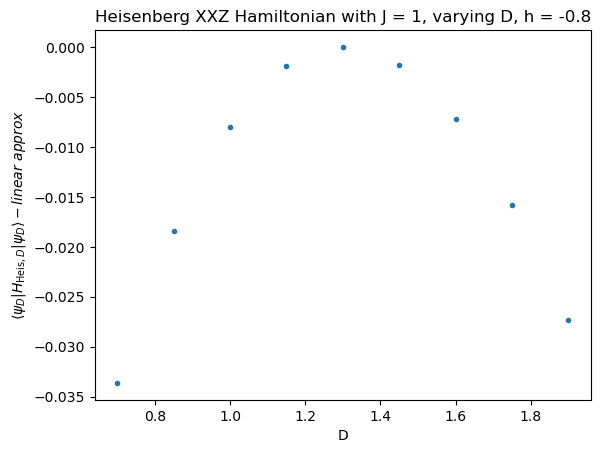

In [20]:
# difference
plt.plot(Dlist, avr_eig_list - np.array([avr_eig + grad_eig[3]*(Di - D) for Di in Dlist]), '.')
plt.xlabel("D")
plt.ylabel(r"$\langle \psi_D | H_{\mathrm{Heis}, D} | \psi_D \rangle - linear\ approx$")
plt.title(f"Heisenberg XXZ Hamiltonian with J = {J}, varying D, h = {h}")
plt.show()